# **Applying SVM in practice**

Author:
* Nguyen Thanh Hy
* Le Tin Nghia
* Tran Nhu Cam Nguyen

We used `SVM` model for classifying `spam` and `ham` message

If you run locally, we advise you choose device with `at least` :
* 2GB GPU RAM
* 8GB RAM
* 1GB SSD free

# Preparing data and environment

In [ ]:
!gdown 1owIRr9DDwMV82cuv6dVL0Cn7brKu17um

Downloading...
From: https://drive.google.com/uc?id=1owIRr9DDwMV82cuv6dVL0Cn7brKu17um
To: /content/SMS_dataset.csv
100% 5.49M/5.49M [00:00<00:00, 303MB/s]


In [ ]:
%%capture
!pip install -U sentence-transformers

# Import necessary libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from keras.utils import to_categorical

from sentence_transformers import SentenceTransformer

# Pipeline

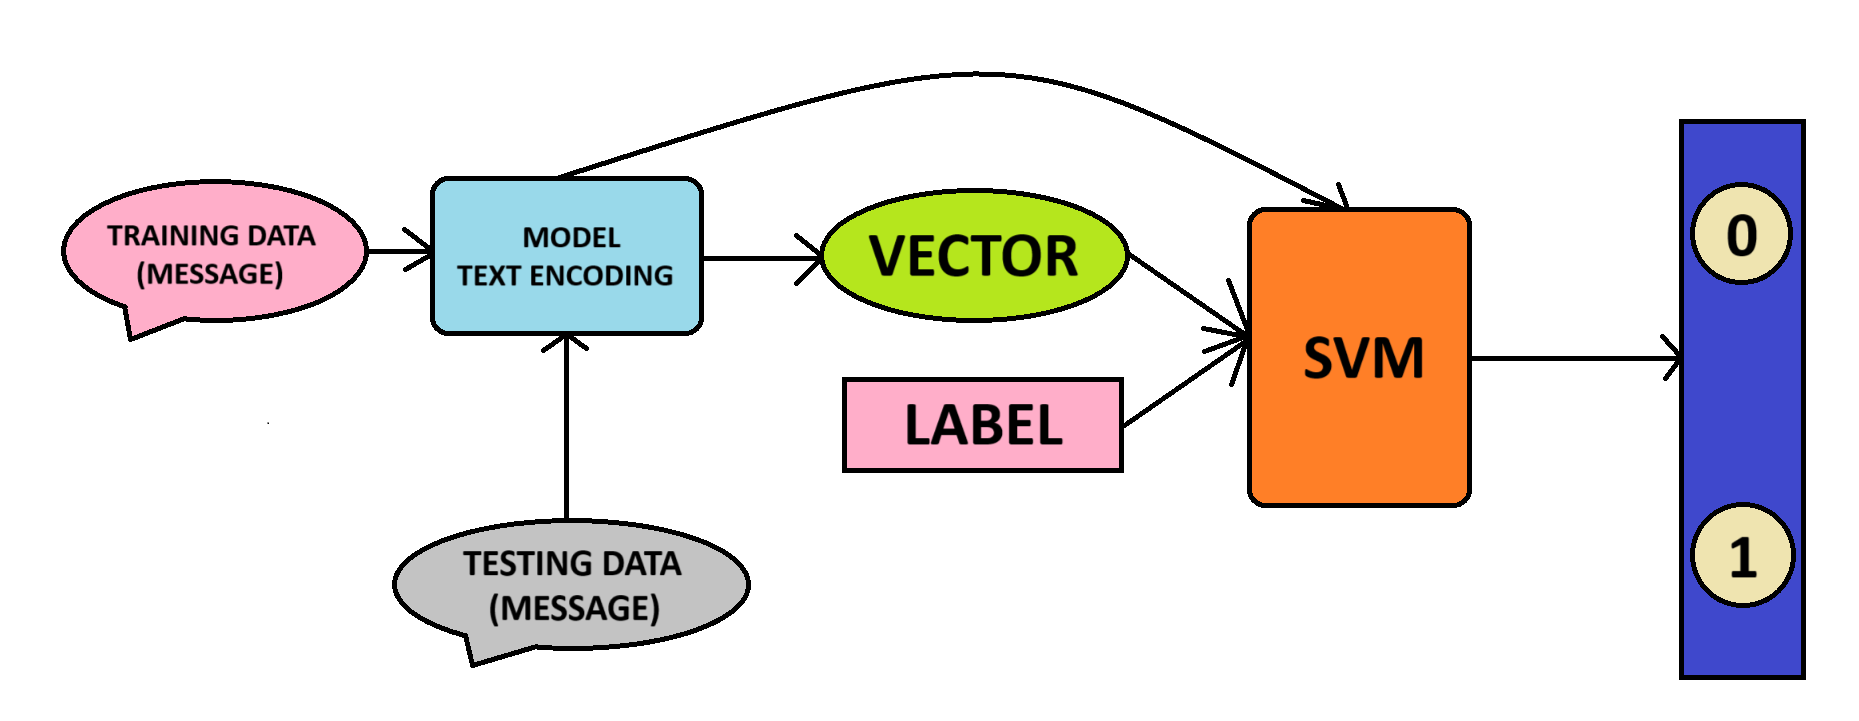

# Load `model text encoding`

In [ ]:
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

.gitattributes:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

data_config.json:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

train_script.py:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

# Read and preprocess data

In [ ]:
df = pd.read_csv('SMS_dataset.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5171 non-null   int64 
 1   label       5171 non-null   object
 2   text        5171 non-null   object
dtypes: int64(1), object(2)
memory usage: 121.3+ KB


Data has:
* 5171 row
* 3 columns: `Unnamed: 0`, `label`, `text`
* 5717 non-null rows

In [ ]:
df

,Unnamed: 0,label,text
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see..."
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar..."
3,4685,spam,"Subject: photoshop , windows , office . cheap ..."
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...
...,...,...,...
5166,1518,ham,Subject: put the 10 on the ft\r\nthe transport...
5167,404,ham,Subject: 3 / 4 / 2000 and following noms\r\nhp...
5168,2933,ham,Subject: calpine daily gas nomination\r\n>\r\n...
5169,1409,ham,Subject: industrial worksheets for august 2000...


In [ ]:
df = df.drop('Unnamed: 0', axis=1)

In [ ]:
print(df['text'][0])

Subject: enron methanol ; meter # : 988291
this is a follow up to the note i gave you on monday , 4 / 3 / 00 { preliminary
flow data provided by daren } .
please override pop ' s daily volume { presently zero } to reflect daily
activity you can obtain from gas control .
this change is needed asap for economics purposes .


We ussually eliminate `stop-word` when we preprocess `text-data`

But this is `SMS-data` so we can not delete any words in this data since that might change meaning of SMS

We saw each row in `text` columns has `Subject: ` and we thought that is not necessary

In [ ]:
for i in range(len(df)):
  df['text'][i] = df['text'][i][9:]

Next, we encoded `SMS` to `vector-384-dimesions`

In [ ]:
df['vec'] = ''
for i in range(len(df)):
  df['vec'][i] = model.encode(df['text'][i])

**After**, we used `Ordinal encoding` skill to tranform columns `label` to `num`

In [ ]:
label = ['ham', 'spam']
df['label'] = df['label'].apply(lambda x: label.index(x))

In [ ]:
df

,label,text,vec
0,0,enron methanol ; meter # : 988291\r\nthis is a...,"[-0.09178408, 0.031082056, -0.043102134, 0.049..."
1,0,"hpl nom for january 9 , 2001\r\n( see attached...","[-0.08762325, -0.010537123, -0.008639316, -0.0..."
2,0,"neon retreat\r\nho ho ho , we ' re around to t...","[-0.044378303, 0.052554384, 0.07136027, 0.0617..."
3,1,"photoshop , windows , office . cheap . main tr...","[0.01813966, -0.050276037, 0.046220362, 0.0320..."
4,0,re : indian springs\r\nthis deal is to book th...,"[-0.020362897, 0.020415733, -0.046874207, 0.02..."
...,...,...,...
5166,0,put the 10 on the ft\r\nthe transport volumes ...,"[-0.07249135, 0.026396902, -0.023526266, -0.03..."
5167,0,3 / 4 / 2000 and following noms\r\nhpl can ' t...,"[-0.06449339, -0.07089319, -0.028549507, 0.014..."
5168,0,calpine daily gas nomination\r\n>\r\n>\r\njuli...,"[-0.047187865, -0.046950847, -0.011005971, 0.0..."
5169,0,industrial worksheets for august 2000 activity...,"[-0.08042309, -0.025941882, -0.0148454495, 0.0..."


We seperated data to `train` and `test_and_val` data with `test_size = 0.2`

In [ ]:
X_train, X_test_and_val, y_train, y_test_and_val = train_test_split(df['vec'], df['label'], test_size=0.2)

After, we continuous seperated `test_and_val` data to `test` data and `val`(validation) data with test_size=0.4

In [ ]:
X_test, X_val, y_test, y_val = train_test_split(X_test_and_val, y_test_and_val, test_size=0.4)

In [ ]:
X_train = np.array(X_train.to_list())
X_test = np.array(X_test.to_list())
X_val = np.array(X_val.to_list())

y_train = np.array(y_train.to_list())
y_test = np.array(y_test.to_list())
y_val = np.array(y_val.to_list())

# EDA

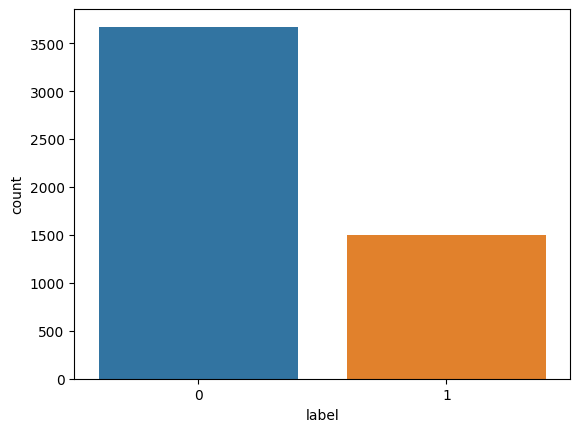

In [ ]:
sns.countplot(x=df['label']);

We can see the number of `spam` message significantly less than `ham` message

I used `PCA` method to decrease dimesion of data from `384` to `2` to visualize data, but I used data with `384` dimesion for training

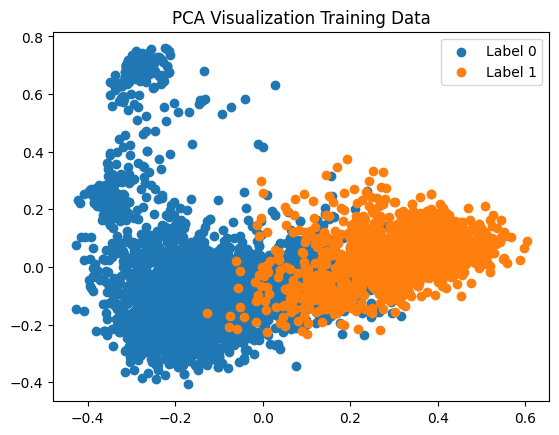

In [ ]:
pca = PCA(n_components=2)
transformed_data = pca.fit_transform(X_train)

unique_labels = list(set(y_train))

for label in unique_labels:
    indices = y_train == label
    plt.scatter(transformed_data[indices, 0], transformed_data[indices, 1], label=f'Label {label}')

plt.title('PCA Visualization Training Data')
plt.legend()
plt.show()

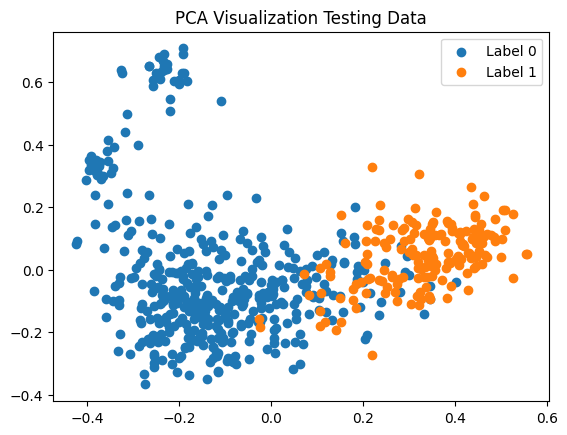

In [ ]:
transformed_data = pca.fit_transform(X_test)

unique_labels = list(set(y_test))

for label in unique_labels:
    indices = y_test == label
    plt.scatter(transformed_data[indices, 0], transformed_data[indices, 1], label=f'Label {label}')

plt.title('PCA Visualization Testing Data')
plt.legend()
plt.show()

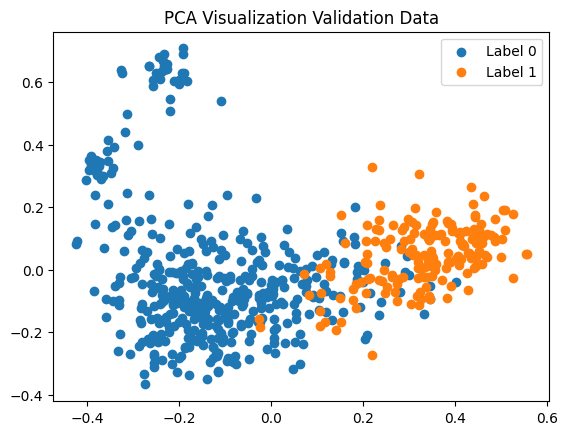

In [ ]:
transformed_data = pca.fit_transform(X_test)

unique_labels = list(set(y_val))

for label in unique_labels:
    indices = y_test == label
    plt.scatter(transformed_data[indices, 0], transformed_data[indices, 1], label=f'Label {label}')

plt.title('PCA Visualization Validation Data')
plt.legend()
plt.show()

Next, we used `t-SNE` tp scale data into `2-dimesions` and visualize them

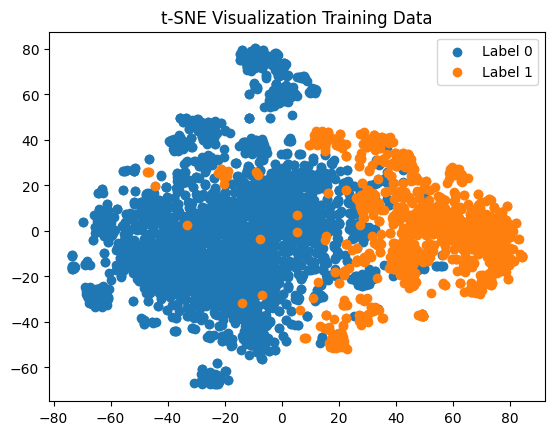

In [ ]:
tsne = TSNE(n_components=2, random_state=42)

transformed_data = tsne.fit_transform(X_train)

unique_labels = list(set(y_train))

for label in unique_labels:
    indices = y_train == label
    plt.scatter(transformed_data[indices, 0], transformed_data[indices, 1], label=f'Label {label}')

plt.title('t-SNE Visualization Training Data')
plt.legend()
plt.show()

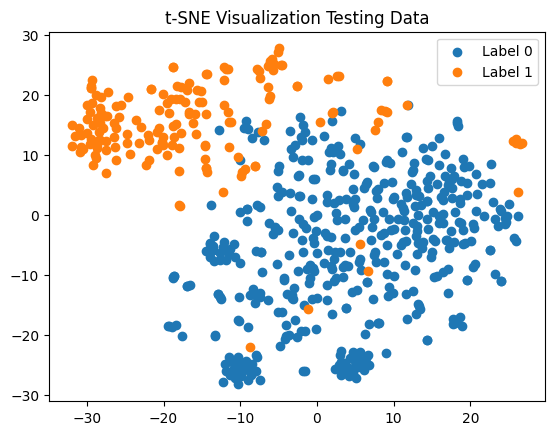

In [ ]:
tsne = TSNE(n_components=2, random_state=42)

transformed_data = tsne.fit_transform(X_test)

unique_labels = list(set(y_test))

for label in unique_labels:
    indices = y_test == label
    plt.scatter(transformed_data[indices, 0], transformed_data[indices, 1], label=f'Label {label}')

plt.title('t-SNE Visualization Testing Data')
plt.legend()
plt.show()

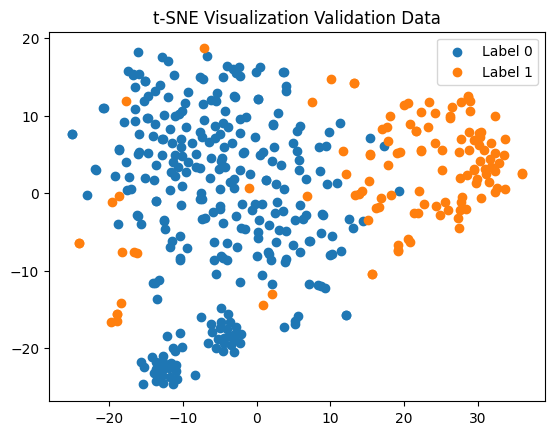

In [ ]:
tsne = TSNE(n_components=2, random_state=42)

transformed_data = tsne.fit_transform(X_val)

unique_labels = list(set(y_val))

for label in unique_labels:
    indices = y_val == label
    plt.scatter(transformed_data[indices, 0], transformed_data[indices, 1], label=f'Label {label}')

plt.title('t-SNE Visualization Validation Data')
plt.legend()
plt.show()

# Prepare **SVM** model and select hyper parameter

I chose `kernel = sigmoid`, `random_state = 42` for SVM model named `svm`

In [ ]:
svm = SVC(random_state=42)

But I can not know the most suitable hyper parameter for `svm` model

So I used `Grid Search` for `choosing suitable parameter`

In [ ]:
param_grid = {'C': [0.3, 6, 9],
              'gamma': [0.01, 0.1, 1],
              'kernel': ['linear', 'sigmoid', 'poly', 'rbf'],
             }

grid_search = GridSearchCV(svm, param_grid, cv=6)
grid_search.fit(X_val, y_val)

print("Best parameters:", grid_search.best_params_)

Best parameters: {'C': 6, 'gamma': 1, 'kernel': 'rbf'}


In [ ]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,mean_test_score,std_test_score,rank_test_score
0,0.011710,0.001047,0.002473,0.000237,0.3,0.01,linear,"{'C': 0.3, 'gamma': 0.01, 'kernel': 'linear'}",0.956522,0.927536,0.927536,0.956522,0.971014,0.985507,0.954106,0.021196,5
1,0.018870,0.004686,0.004829,0.002657,0.3,0.01,sigmoid,"{'C': 0.3, 'gamma': 0.01, 'kernel': 'sigmoid'}",0.710145,0.710145,0.710145,0.710145,0.710145,0.710145,0.710145,0.000000,28
2,0.014300,0.000833,0.003247,0.000142,0.3,0.01,poly,"{'C': 0.3, 'gamma': 0.01, 'kernel': 'poly'}",0.710145,0.710145,0.710145,0.710145,0.710145,0.710145,0.710145,0.000000,28
3,0.015177,0.000313,0.008307,0.000135,0.3,0.01,rbf,"{'C': 0.3, 'gamma': 0.01, 'kernel': 'rbf'}",0.710145,0.710145,0.710145,0.710145,0.710145,0.710145,0.710145,0.000000,28
4,0.009992,0.000339,0.002335,0.000144,0.3,0.1,linear,"{'C': 0.3, 'gamma': 0.1, 'kernel': 'linear'}",0.956522,0.927536,0.927536,0.956522,0.971014,0.985507,0.954106,0.021196,5
5,0.017012,0.000713,0.003852,0.000295,0.3,0.1,sigmoid,"{'C': 0.3, 'gamma': 0.1, 'kernel': 'sigmoid'}",0.710145,0.710145,0.710145,0.710145,0.710145,0.710145,0.710145,0.000000,28
6,0.013764,0.001750,0.003046,0.000076,0.3,0.1,poly,"{'C': 0.3, 'gamma': 0.1, 'kernel': 'poly'}",0.710145,0.710145,0.710145,0.710145,0.710145,0.710145,0.710145,0.000000,28
7,0.015622,0.001323,0.007986,0.000256,0.3,0.1,rbf,"{'C': 0.3, 'gamma': 0.1, 'kernel': 'rbf'}",0.826087,0.797101,0.768116,0.840580,0.811594,0.811594,0.809179,0.022787,26
8,0.011951,0.004558,0.002375,0.000163,0.3,1,linear,"{'C': 0.3, 'gamma': 1, 'kernel': 'linear'}",0.956522,0.927536,0.927536,0.956522,0.971014,0.985507,0.954106,0.021196,5
9,0.012168,0.000200,0.003936,0.002402,0.3,1,sigmoid,"{'C': 0.3, 'gamma': 1, 'kernel': 'sigmoid'}",0.956522,0.927536,0.927536,0.956522,0.956522,0.985507,0.951691,0.019918,17


We chose `best parameter` for `training` and `testing` because `validation` is not too large

# Training

In [ ]:
svm = SVC(C= 6, kernel= 'rbf', gamma= 1, random_state=42)

In [ ]:
svm.fit(X_train, y_train)

SVC(C=6, gamma=1, random_state=42)

# Validation and testing

Try on validation data

In [ ]:
val_pred = svm.predict(X_val)

Fistly, I used `confusion matrix` to watch effectiveness of `svm` on `validation` data

In [ ]:
matrix = confusion_matrix(y_val, val_pred)

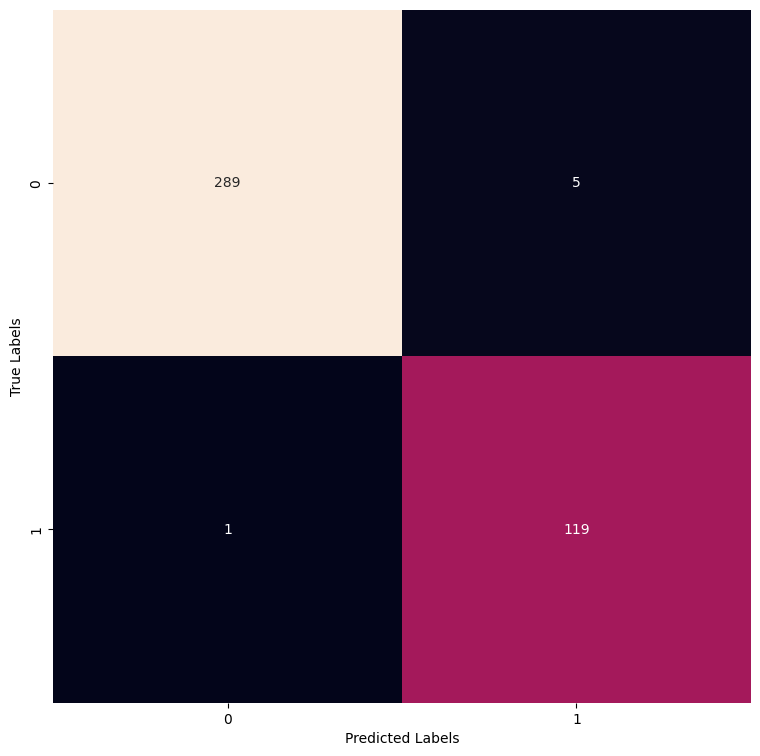

In [ ]:
plt.figure(figsize=(9, 9))
sns.heatmap(matrix, annot=True, fmt="d", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels");

Beside, I used `accuray_score` method to see effectiveness of `svm`

In [ ]:
acc = accuracy_score(y_val, val_pred)
acc

0.9855072463768116

Finally, we tried on testing data

In [ ]:
pred = svm.predict(X_test)

We created `confusion matrix` to see effectiveness of `svm` model on reality data

In [ ]:
matrix = confusion_matrix(y_test, pred)

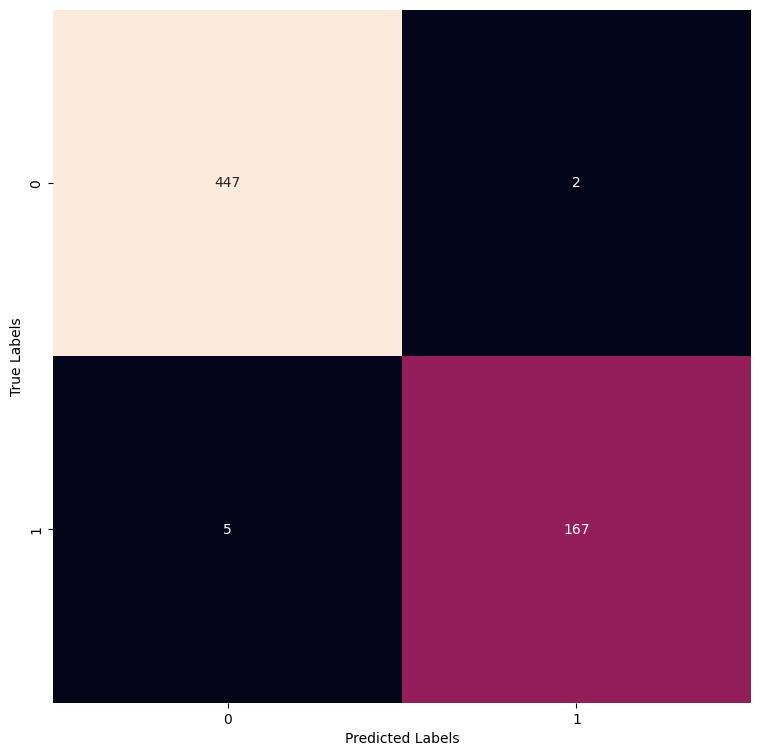

In [ ]:
plt.figure(figsize=(9, 9))
sns.heatmap(matrix, annot=True, fmt="d", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels");

In [ ]:
acc = accuracy_score(y_test, pred)
acc

0.9887278582930756

Look at the result we can see, `svm` model demonstrated good effect on `reality data`

# Conclusion

* The `Support Vector Machine` (SVM) model emerges as a `highly suitable choice` for tackling the challenging task of `classifying spam SMS messages`. The model's robust performance in distinguishing between spam and non-spam messages underscores its efficacy and reliability in handling this specific classification objective.

* SVM's strength lies in its ability to delineate intricate decision boundaries, allowing it to `effectively capture complex patterns present in the data`. This characteristic proves invaluable in discerning the nuanced differences between legitimate and spam messages, contributing to the model's overall accuracy.

* Moreover, SVM's versatility is evident in its adaptability to `different kernel functions`. The `flexibility` to choose appropriate kernel types, such as the 'rbf' kernel, further enhances the model's capability to map data to higher-dimensional spaces, enabling it to uncover hidden relationships `within the feature space`.

* While the SVM model has demonstrated its effectiveness, there remains room for `fine-tuning` and `optimization`. Adjusting hyperparameters, including `kernel selection` and `regularization strength`, holds the potential to further elevate the model's performance and ensure its robustness across a broader range of scenarios.

In summary, the SVM model proves to be a strong contender for `spam SMS classification`, offering a dependable and resilient solution. Its innate characteristics, coupled with the ability to tailor parameters to specific requirements, position SVM as a `powerful tool in effectively` addressing the challenges posed by spam detection in SMS messages, **but in reality we should consider to use SVM because its may cause `overfitting`**.